# Anomaly Detection for KC Housing Price

<p>For this KC Housing Price dataset, I will utilize some anomaly detection approaches which are the same as used in Beijing Housing Price dataset to find the outliers of the dataset. The main algorithms I utilize for anomaly detection are Interquartile Range (IQR), Isolation Forest, One Class SVM, Local Outlier Factor, Robust Covariance and K-Nearest Neighbors (KNN). Finally, I will combine these models together to calculate the score for each data and select the anomalies which satisfy the threshold of the score, which is the safest way to do unsupervised anomaly detection.</p>

<p>Since this is a problem of unsupervised anomaly detection, I will judge the performance of each method by visualizing the anomalies among the entire dataset. Personally, I think this is an efficient way to make the judgement of the results.</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from pyod.models.knn import KNN

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
%matplotlib inline

In [2]:
df = pd.read_csv('../data/kc_house_data.csv')
df.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


# Some properties of the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


In [4]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
df.isna().any()

id               False
date             False
price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

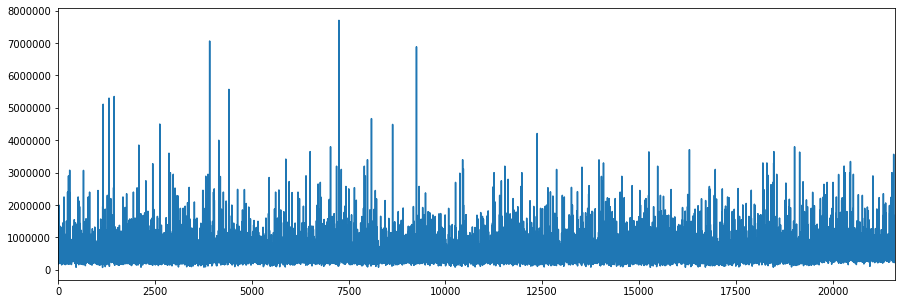

In [6]:
df['price'].plot(figsize=[15, 5])

## Histogram of the dataset

<p>Histogram of the total price.</p>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d8bfa10>]],
      dtype=object)

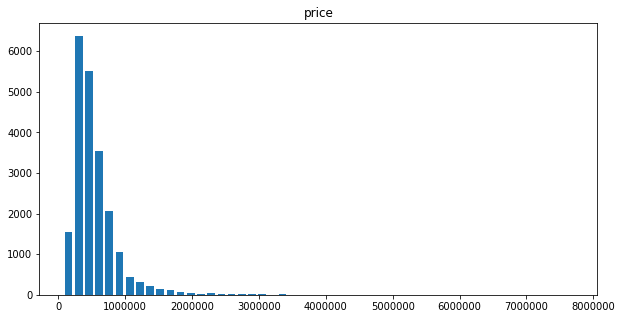

In [7]:
df.hist(column='price', bins=50, grid=False, figsize=[10,5], rwidth=0.75)

# Feature Engineering

## Drop out some unuseful features

In [8]:
df = df.drop(columns=['id', 'date', 'sqft_living15', 'sqft_lot15'])
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045
5,1225000.0,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005
6,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327
7,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315
8,229500.0,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337
9,323000.0,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031


## Calculate the total area of each house

In [9]:
df['sqft'] = df.apply(lambda x: x.sqft_living + x.sqft_lot, axis=1).astype(int)
df['floors'] = df['floors'].astype(int)
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft
0,221900.0,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,6830
1,538000.0,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,9812
2,180000.0,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,10770
3,604000.0,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,6960
4,510000.0,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,9760
5,1225000.0,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350
6,257500.0,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,8534
7,291850.0,3,1.50,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,10771
8,229500.0,3,1.00,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,9250
9,323000.0,3,2.50,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,8450


## Calculate the unit housing price

<p>I calculate the unit price by dividing the price by the area of each house. It is more reasonable to compare the unit price instead of the total price since it is normal that the price of the house is high when the house has larger area.</p>

In [10]:
df['price'] = df.apply(lambda x: x.price/x.sqft, axis=1)
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft
0,32.489019,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,6830
1,54.830819,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,9812
2,16.713092,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,10770
3,86.781609,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,6960
4,52.254098,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,9760
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350
6,30.173424,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,8534
7,27.095906,3,1.50,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,10771
8,24.810811,3,1.00,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,9250
9,38.224852,3,2.50,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,8450


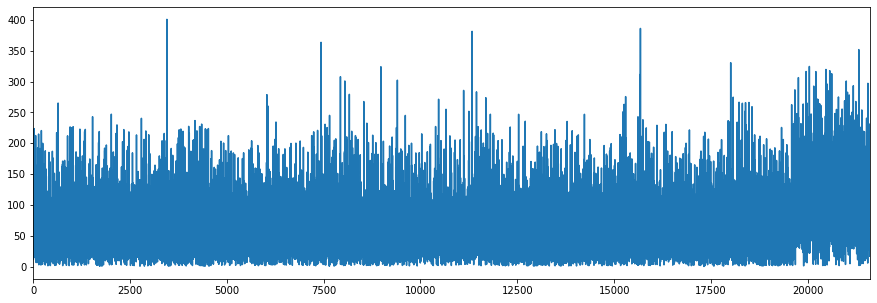

In [11]:
df['price'].plot(figsize=[15, 5])

## Histogram of the unit price

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124a9e350>]],
      dtype=object)

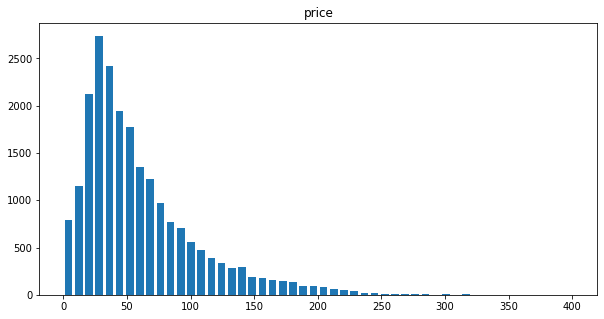

In [12]:
df.hist(column='price', bins=50, grid=False, figsize=[10,5], rwidth=0.75)

## Select Features

In [13]:
data = df[['price', 
           'bedrooms', 
           'bathrooms', 
           'floors', 
           'waterfront', 
           'view', 
           'condition', 
           'grade', 
           'zipcode', 
           'sqft']]
data.head(10)

,price,bedrooms,bathrooms,floors,waterfront,view,condition,grade,zipcode,sqft
0,32.489019,3,1.00,1,0,0,3,7,98178,6830
1,54.830819,3,2.25,2,0,0,3,7,98125,9812
2,16.713092,2,1.00,1,0,0,3,6,98028,10770
3,86.781609,4,3.00,1,0,0,5,7,98136,6960
4,52.254098,3,2.00,1,0,0,3,8,98074,9760
5,11.411272,4,4.50,1,0,0,3,11,98053,107350
6,30.173424,3,2.25,2,0,0,3,7,98003,8534
7,27.095906,3,1.50,1,0,0,3,7,98198,10771
8,24.810811,3,1.00,1,0,0,3,7,98146,9250
9,38.224852,3,2.50,2,0,0,3,7,98038,8450


## PCA

<p>Utilizing PCA to reduce the number of features. 3 components are good enough to do the anomaly detection.</p>

In [14]:
pca = PCA(n_components=3)
pca.fit(data)
data = pca.transform(data)

# Anomaly Detection

## Interquartile Range (IQR)

### Lower bound and upper bound

In [15]:
q1 = df.price.quantile(0.25)
q3 = df.price.quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr)

print('The lower bound of the IQR is {}'.format(lower_bound))
print('The upper bound of the IQR is {}'.format(upper_bound))

The lower bound of the IQR is -46.75667201184068
The upper bound of the IQR is 152.938602451754


### The outliers beyond the bounds

In [16]:
df_outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print('The number of outliers is {}'.format(len(df_outliers.index)))
df_outliers.head(10)

The number of outliers is 1123


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft
26,182.260261,3,1.75,2450,2691,2,0,0,3,8,1750,700,1915,0,98119,47.6386,-122.360,5141
27,223.750419,3,1.00,1400,1581,1,0,0,5,8,1400,0,1909,0,98112,47.6221,-122.314,2981
43,177.922078,3,1.00,1570,2280,2,0,0,3,7,1570,0,1922,0,98119,47.6413,-122.364,3850
63,212.461300,3,1.75,1540,1044,3,0,0,3,8,1540,0,2014,0,98115,47.6765,-122.320,2584
85,163.763066,3,1.50,2140,3600,2,0,0,3,9,1900,240,1925,0,98119,47.6337,-122.365,5740
89,159.828244,2,1.75,1030,1066,2,0,0,3,7,765,265,2006,0,98136,47.5394,-122.387,2096
116,192.607727,3,3.50,1590,1102,3,0,0,3,8,1590,0,2010,0,98103,47.6824,-122.347,2692
139,214.944192,3,2.25,1170,1249,3,0,0,3,8,1170,0,2014,0,98107,47.6722,-122.381,2419
140,154.292343,2,1.00,1110,3200,1,0,0,3,7,1110,0,1925,0,98119,47.6338,-122.358,4310
175,191.441441,3,2.50,1120,1100,2,0,0,3,8,820,300,2008,0,98122,47.6106,-122.310,2220


### Add the results to Data Frame

In [17]:
IQR = np.zeros(df.index.size).astype(int)
IQR[df_outliers.index] = int(-1)
df['IQR'] = IQR
df[df['IQR'] == -1].head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR
26,182.260261,3,1.75,2450,2691,2,0,0,3,8,1750,700,1915,0,98119,47.6386,-122.360,5141,-1
27,223.750419,3,1.00,1400,1581,1,0,0,5,8,1400,0,1909,0,98112,47.6221,-122.314,2981,-1
43,177.922078,3,1.00,1570,2280,2,0,0,3,7,1570,0,1922,0,98119,47.6413,-122.364,3850,-1
63,212.461300,3,1.75,1540,1044,3,0,0,3,8,1540,0,2014,0,98115,47.6765,-122.320,2584,-1
85,163.763066,3,1.50,2140,3600,2,0,0,3,9,1900,240,1925,0,98119,47.6337,-122.365,5740,-1
89,159.828244,2,1.75,1030,1066,2,0,0,3,7,765,265,2006,0,98136,47.5394,-122.387,2096,-1
116,192.607727,3,3.50,1590,1102,3,0,0,3,8,1590,0,2010,0,98103,47.6824,-122.347,2692,-1
139,214.944192,3,2.25,1170,1249,3,0,0,3,8,1170,0,2014,0,98107,47.6722,-122.381,2419,-1
140,154.292343,2,1.00,1110,3200,1,0,0,3,7,1110,0,1925,0,98119,47.6338,-122.358,4310,-1
175,191.441441,3,2.50,1120,1100,2,0,0,3,8,820,300,2008,0,98122,47.6106,-122.310,2220,-1


### Visualize the Anomaly Detection with IQR

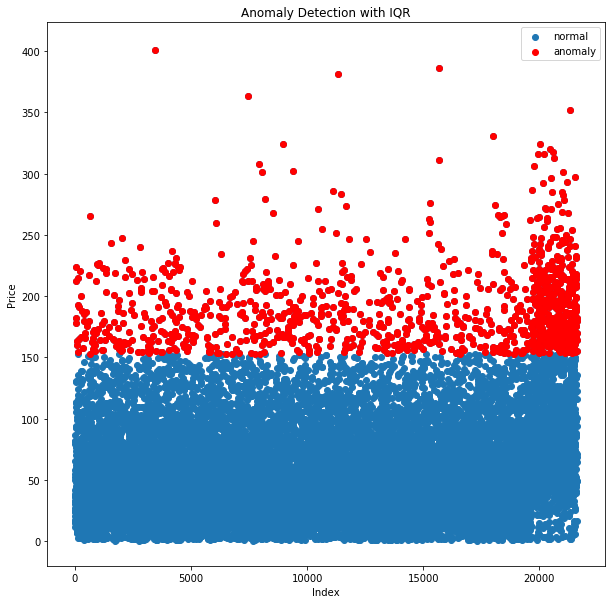

In [18]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['IQR'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with IQR')
plt.legend()
plt.show()

### Distribution of the anomalies detected by IQR

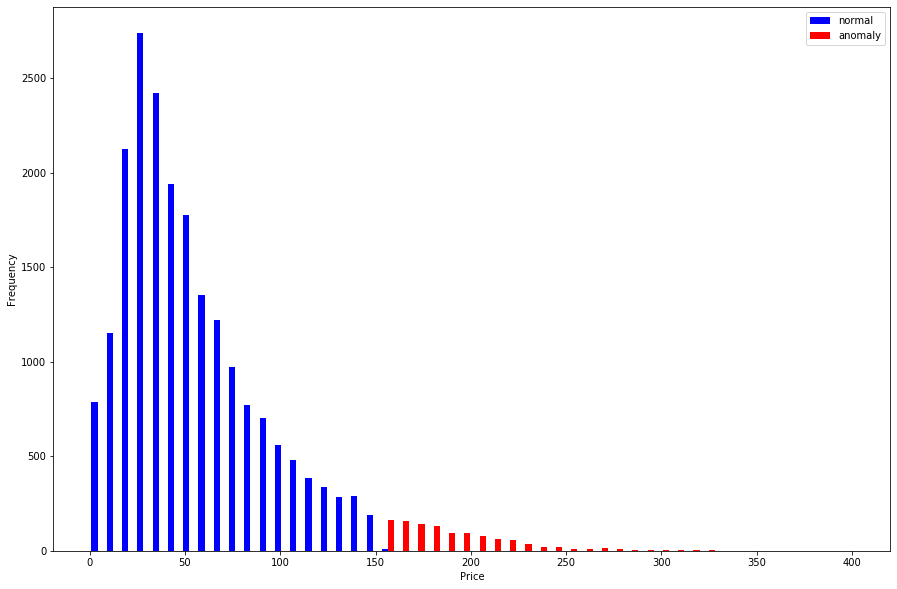

In [19]:
normal = df.loc[df['IQR'] == 0, 'price']
anomaly = df.loc[df['IQR'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Isolation Forest

In [20]:
isolation_forest = IsolationForest(n_estimators=1000, max_samples=5000, contamination=0.055)
isolation_forest.fit(data)
outliers_prediction = isolation_forest.predict(data)
outliers_prediction[outliers_prediction == 1] = 0
df['IsolationForest'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['IsolationForest'] == -1].head(10)

The number of outliers is 1189


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR,IsolationForest
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350,0,-1
91,111.402816,5,2.75,3520,6353,2,0,0,4,10,3520,0,2001,0,98199,47.6506,-122.391,9873,0,-1
102,6.375759,3,2.25,2190,107593,2,0,0,4,8,2190,0,1983,0,98077,47.7731,-122.080,109783,0,-1
107,50.495580,2,1.75,1240,2493,1,0,0,4,8,1240,0,1985,0,98198,47.3813,-122.322,3733,0,-1
132,6.815732,3,3.50,3950,111078,1,0,0,3,9,2460,1490,1989,0,98052,47.6970,-122.072,115028,0,-1
145,2.888316,4,2.50,3670,315374,2,0,0,4,9,3670,0,1994,0,98077,47.7421,-122.026,319044,0,-1
153,89.892129,4,3.25,5180,19850,2,0,3,3,12,3540,1640,2006,0,98006,47.5620,-122.162,25030,0,-1
199,2.461275,3,1.75,1350,155073,1,0,0,4,7,1350,0,1969,0,98038,47.4058,-121.994,156423,0,-1
236,4.309988,3,2.00,2220,94300,1,0,0,5,7,1640,580,1976,0,98010,47.3459,-121.950,96520,0,-1
238,3.553755,3,3.50,3830,221284,2,0,0,3,10,3530,300,1993,0,98077,47.7641,-122.023,225114,0,-1


### Visualize the Anomaly Detection with Isolation Forest

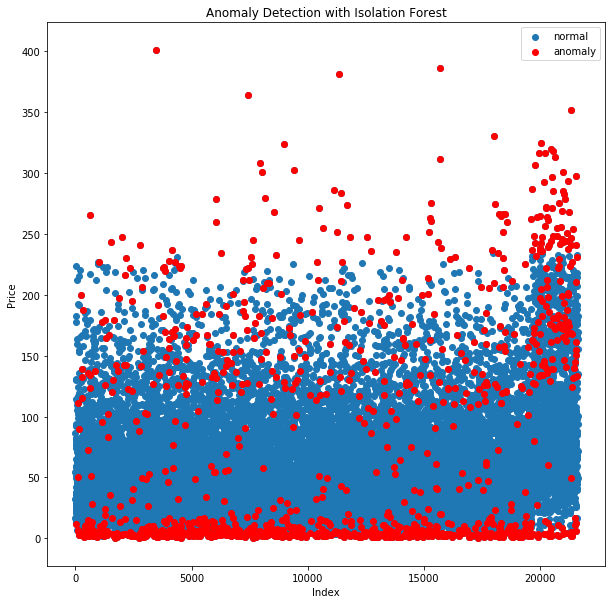

In [21]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['IsolationForest'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with Isolation Forest')
plt.legend()
plt.show()

### Distribution of the anomalies detected by Isolation Forest

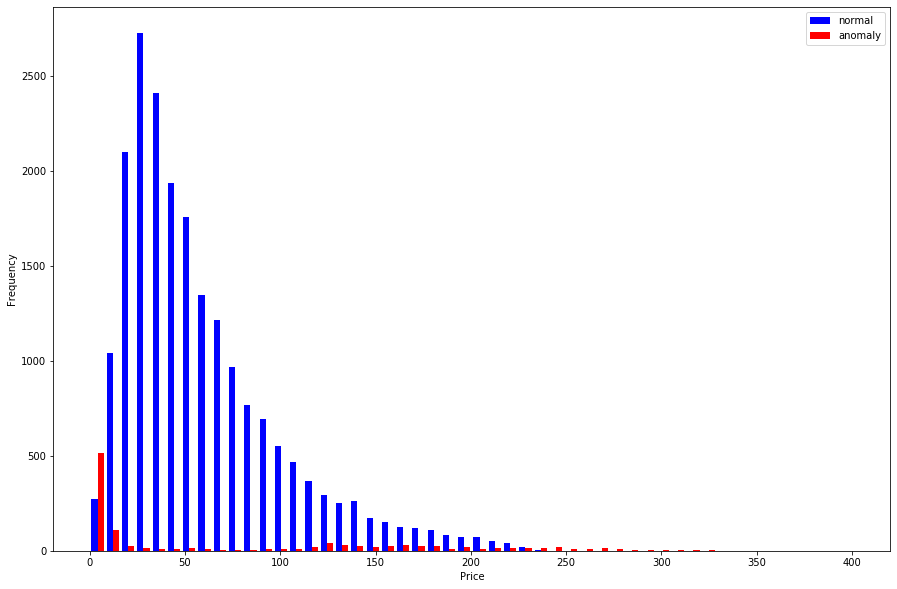

In [22]:
normal = df.loc[df['IsolationForest'] == 0, 'price']
anomaly = df.loc[df['IsolationForest'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## One Class SVM

In [23]:
one_class_svm = OneClassSVM(gamma=0.000005, nu=0.055)
one_class_svm.fit(data)
outliers_prediction = one_class_svm.predict(data)
outliers_prediction[outliers_prediction == 1] = 0
df['OneClassSVM'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['OneClassSVM'] == -1].head(10)

The number of outliers is 1195


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR,IsolationForest,OneClassSVM
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350,0,-1,-1
41,27.282968,4,2.25,4220,24186,1,0,0,3,8,2600,1620,1984,0,98166,47.4450,-122.347,28406,0,0,-1
70,18.955964,5,3.25,4770,50094,1,0,0,4,11,3070,1700,1973,0,98005,47.6525,-122.160,54864,0,0,-1
102,6.375759,3,2.25,2190,107593,2,0,0,4,8,2190,0,1983,0,98077,47.7731,-122.080,109783,0,-1,-1
107,50.495580,2,1.75,1240,2493,1,0,0,4,8,1240,0,1985,0,98198,47.3813,-122.322,3733,0,-1,-1
132,6.815732,3,3.50,3950,111078,1,0,0,3,9,2460,1490,1989,0,98052,47.6970,-122.072,115028,0,-1,-1
145,2.888316,4,2.50,3670,315374,2,0,0,4,9,3670,0,1994,0,98077,47.7421,-122.026,319044,0,-1,-1
198,6.459095,3,2.50,1910,66211,2,0,0,3,7,1910,0,1997,0,98024,47.5385,-121.911,68121,0,0,-1
199,2.461275,3,1.75,1350,155073,1,0,0,4,7,1350,0,1969,0,98038,47.4058,-121.994,156423,0,-1,-1
236,4.309988,3,2.00,2220,94300,1,0,0,5,7,1640,580,1976,0,98010,47.3459,-121.950,96520,0,-1,-1


### Visualize the Anomaly Detection with One Class SVM

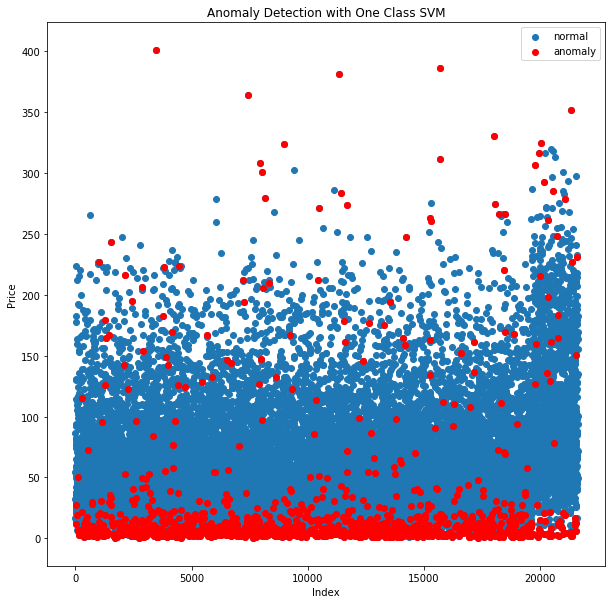

In [24]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['OneClassSVM'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with One Class SVM')
plt.legend()
plt.show()

### Distribution of the anomalies detected by One Class SVM

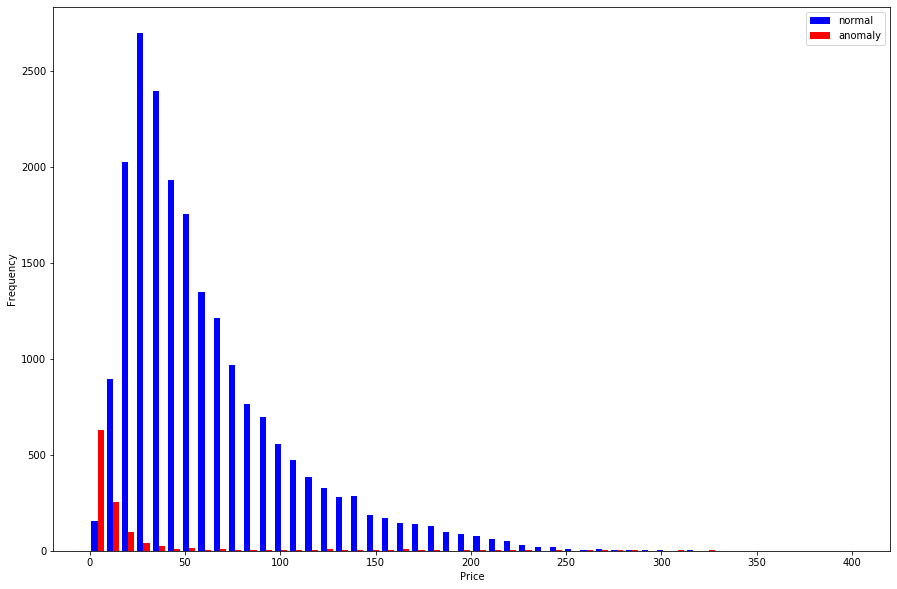

In [25]:
normal = df.loc[df['OneClassSVM'] == 0, 'price']
anomaly = df.loc[df['OneClassSVM'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Local Outlier Factor

In [26]:
local_outlier_factor = LocalOutlierFactor(n_neighbors=300, contamination=0.055)
outliers_prediction = local_outlier_factor.fit_predict(data)
outliers_prediction[outliers_prediction == 1] = 0
df['LocalOutlierFactor'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['LocalOutlierFactor'] == -1].head(10)

The number of outliers is 1189


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350,0,-1,-1,-1
7,27.095906,3,1.50,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,10771,0,0,0,-1
49,19.923847,3,2.50,2753,65005,1,1,2,5,9,2165,588,1953,0,98070,47.4041,-122.451,67758,0,0,0,-1
89,159.828244,2,1.75,1030,1066,2,0,0,3,7,765,265,2006,0,98136,47.5394,-122.387,2096,-1,0,0,-1
91,111.402816,5,2.75,3520,6353,2,0,0,4,10,3520,0,2001,0,98199,47.6506,-122.391,9873,0,-1,0,-1
102,6.375759,3,2.25,2190,107593,2,0,0,4,8,2190,0,1983,0,98077,47.7731,-122.080,109783,0,-1,-1,-1
132,6.815732,3,3.50,3950,111078,1,0,0,3,9,2460,1490,1989,0,98052,47.6970,-122.072,115028,0,-1,-1,-1
145,2.888316,4,2.50,3670,315374,2,0,0,4,9,3670,0,1994,0,98077,47.7421,-122.026,319044,0,-1,-1,-1
147,6.781907,2,2.50,2420,60984,2,0,0,3,7,2420,0,2007,0,98027,47.5262,-121.943,63404,0,0,0,-1
198,6.459095,3,2.50,1910,66211,2,0,0,3,7,1910,0,1997,0,98024,47.5385,-121.911,68121,0,0,-1,-1


### Visualize the Anomaly Detection with Local Outlier Factor

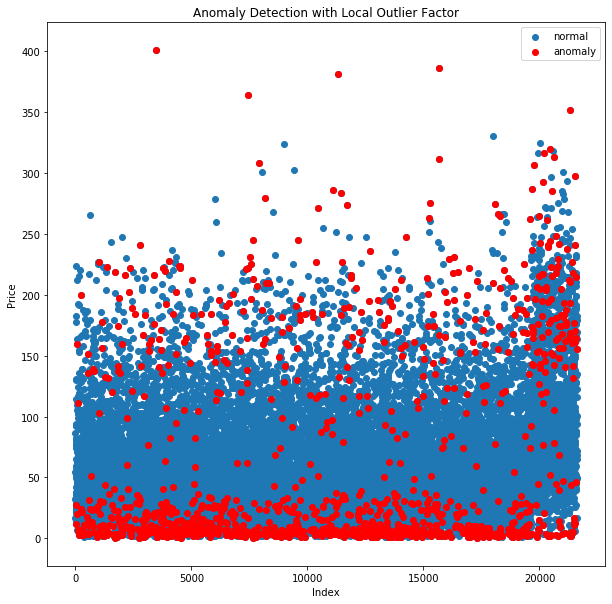

In [27]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['LocalOutlierFactor'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with Local Outlier Factor')
plt.legend()
plt.show()

### Distribution of the anomalies detected by Local Outlier Factor

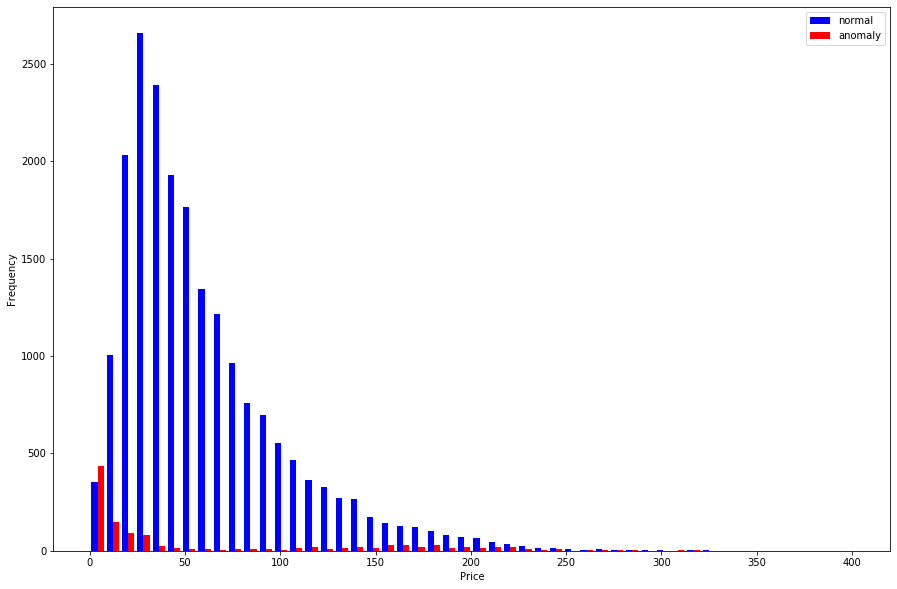

In [28]:
normal = df.loc[df['LocalOutlierFactor'] == 0, 'price']
anomaly = df.loc[df['LocalOutlierFactor'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Robust Covariance

In [29]:
elliptic_envelope = EllipticEnvelope(assume_centered=True, support_fraction=1, contamination=0.055)
elliptic_envelope.fit(data)
outliers_prediction = elliptic_envelope.predict(data)
outliers_prediction[outliers_prediction == 1] = 0
df['RobustCovariance'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['RobustCovariance'] == -1].head(10)

The number of outliers is 1189


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350,0,-1,-1,-1,-1
27,223.750419,3,1.00,1400,1581,1,0,0,5,8,1400,0,1909,0,98112,47.6221,-122.314,2981,-1,0,0,0,-1
49,19.923847,3,2.50,2753,65005,1,1,2,5,9,2165,588,1953,0,98070,47.4041,-122.451,67758,0,0,0,-1,-1
63,212.461300,3,1.75,1540,1044,3,0,0,3,8,1540,0,2014,0,98115,47.6765,-122.320,2584,-1,0,0,0,-1
102,6.375759,3,2.25,2190,107593,2,0,0,4,8,2190,0,1983,0,98077,47.7731,-122.080,109783,0,-1,-1,-1,-1
116,192.607727,3,3.50,1590,1102,3,0,0,3,8,1590,0,2010,0,98103,47.6824,-122.347,2692,-1,0,0,0,-1
132,6.815732,3,3.50,3950,111078,1,0,0,3,9,2460,1490,1989,0,98052,47.6970,-122.072,115028,0,-1,-1,-1,-1
139,214.944192,3,2.25,1170,1249,3,0,0,3,8,1170,0,2014,0,98107,47.6722,-122.381,2419,-1,0,0,0,-1
145,2.888316,4,2.50,3670,315374,2,0,0,4,9,3670,0,1994,0,98077,47.7421,-122.026,319044,0,-1,-1,-1,-1
175,191.441441,3,2.50,1120,1100,2,0,0,3,8,820,300,2008,0,98122,47.6106,-122.310,2220,-1,0,0,0,-1


### Visualize the Anomaly Detection with Robust Covariance

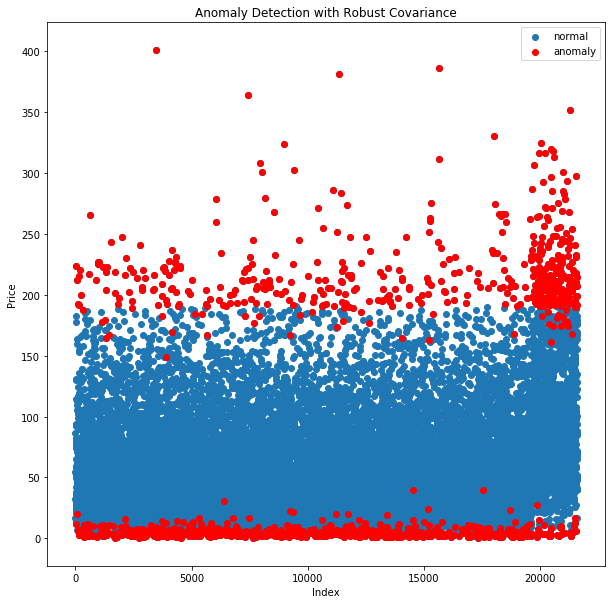

In [30]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['RobustCovariance'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with Robust Covariance')
plt.legend()
plt.show()

### Distribution of the anomalies detected by Robust Covariance

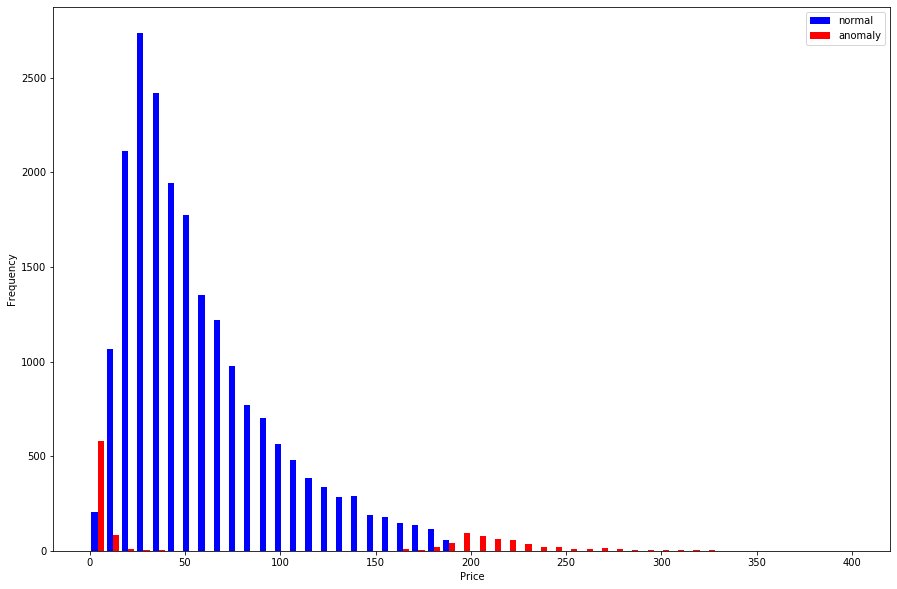

In [31]:
normal = df.loc[df['RobustCovariance'] == 0, 'price']
anomaly = df.loc[df['RobustCovariance'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## KNN

In [32]:
knn = KNN(contamination=0.055, n_neighbors=5)
knn.fit(data)
outliers_prediction = knn.labels_
outliers_prediction[outliers_prediction == 1] = -1
df['KNN'] = outliers_prediction
print('The number of outliers is {}'.format(list(outliers_prediction).count(-1)))
df[df['KNN'] == -1].head(10)

The number of outliers is 1189


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance,KNN
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350,0,-1,-1,-1,-1,-1
49,19.923847,3,2.50,2753,65005,1,1,2,5,9,2165,588,1953,0,98070,47.4041,-122.451,67758,0,0,0,-1,-1,-1
60,27.795595,3,2.25,2150,21235,1,0,3,4,8,1590,560,1959,0,98166,47.4336,-122.339,23385,0,0,0,0,0,-1
70,18.955964,5,3.25,4770,50094,1,0,0,4,11,3070,1700,1973,0,98005,47.6525,-122.160,54864,0,0,-1,0,0,-1
102,6.375759,3,2.25,2190,107593,2,0,0,4,8,2190,0,1983,0,98077,47.7731,-122.080,109783,0,-1,-1,-1,-1,-1
132,6.815732,3,3.50,3950,111078,1,0,0,3,9,2460,1490,1989,0,98052,47.6970,-122.072,115028,0,-1,-1,-1,-1,-1
145,2.888316,4,2.50,3670,315374,2,0,0,4,9,3670,0,1994,0,98077,47.7421,-122.026,319044,0,-1,-1,-1,-1,-1
147,6.781907,2,2.50,2420,60984,2,0,0,3,7,2420,0,2007,0,98027,47.5262,-121.943,63404,0,0,0,-1,0,-1
170,12.588652,3,1.75,1560,21000,1,0,0,3,7,1560,0,1954,0,98166,47.4776,-122.337,22560,0,0,0,0,0,-1
198,6.459095,3,2.50,1910,66211,2,0,0,3,7,1910,0,1997,0,98024,47.5385,-121.911,68121,0,0,-1,-1,-1,-1


### Visualize the Anomaly Detection with KNN

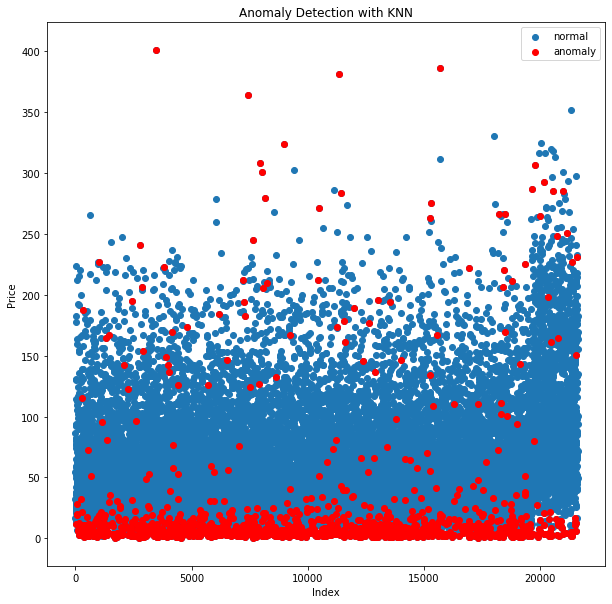

In [33]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df.loc[df['KNN'] == -1,  ['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index, a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with KNN')
plt.legend()
plt.show()

### Distribution of the anomalies detected by KNN

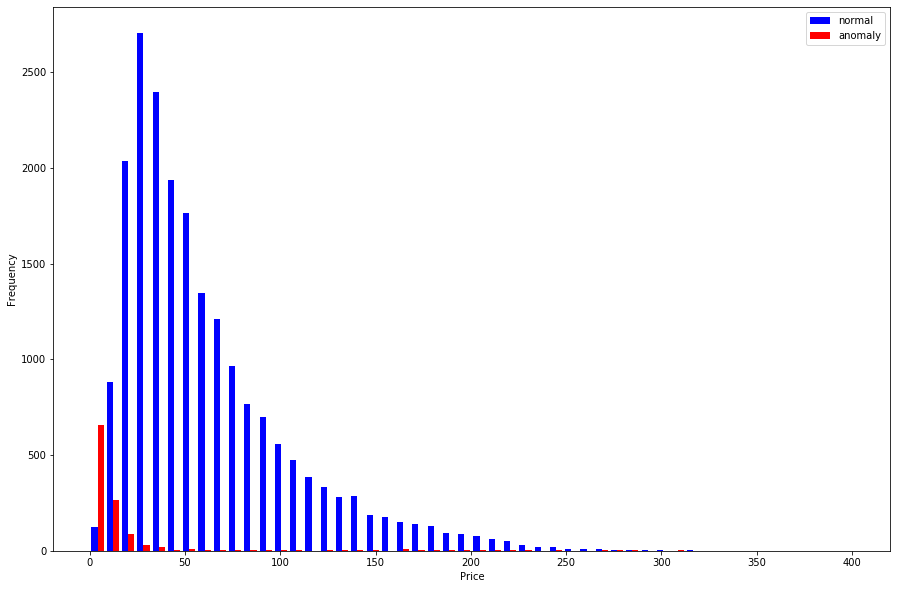

In [34]:
normal = df.loc[df['KNN'] == 0, 'price']
anomaly = df.loc[df['KNN'] == -1, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Combination of all Models

<p>For each model, if the model thinks one data is anomaly point, then it will be denoted as -1 by this model. If the model thinks one data is normal point, it will be denoted as 0 by this model.</p>
<p>After the anomaly detection for each model, I sum up the score for each data. Totally we have 6 models for anomaly detection. If a data has score less than or equal to -4 which means at least 4 models think it as anomaly, it will be treated as anomaly point. Otherwise, the point is normal.</p>

In [35]:
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance,KNN
0,32.489019,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,6830,0,0,0,0,0,0
1,54.830819,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,9812,0,0,0,0,0,0
2,16.713092,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,10770,0,0,0,0,0,0
3,86.781609,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,6960,0,0,0,0,0,0
4,52.254098,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,9760,0,0,0,0,0,0
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350,0,-1,-1,-1,-1,-1
6,30.173424,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,8534,0,0,0,0,0,0
7,27.095906,3,1.50,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,10771,0,0,0,-1,0,0
8,24.810811,3,1.00,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,9250,0,0,0,0,0,0
9,38.224852,3,2.50,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,8450,0,0,0,0,0,0


### Calculate the anomaly score with all models

In [36]:
df['AnomalyScore'] = df.apply(lambda x: int(x.IQR + 
                                            x.IsolationForest + 
                                            x.OneClassSVM + 
                                            x.LocalOutlierFactor + 
                                            x.RobustCovariance + 
                                            x.KNN), 
                              axis=1)
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance,KNN,AnomalyScore
0,32.489019,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,6830,0,0,0,0,0,0,0
1,54.830819,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,9812,0,0,0,0,0,0,0
2,16.713092,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,10770,0,0,0,0,0,0,0
3,86.781609,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,6960,0,0,0,0,0,0,0
4,52.254098,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,9760,0,0,0,0,0,0,0
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350,0,-1,-1,-1,-1,-1,-5
6,30.173424,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,8534,0,0,0,0,0,0,0
7,27.095906,3,1.50,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,10771,0,0,0,-1,0,0,-1
8,24.810811,3,1.00,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,9250,0,0,0,0,0,0,0
9,38.224852,3,2.50,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,8450,0,0,0,0,0,0,0


### Select the outliers by setting a threshold of the anomaly score

In [37]:
df_outliers = df[df['AnomalyScore'] <= -4]
df_outliers.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,IQR,IsolationForest,OneClassSVM,LocalOutlierFactor,RobustCovariance,KNN,AnomalyScore
5,11.411272,4,4.50,5420,101930,1,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,107350,0,-1,-1,-1,-1,-1,-5
102,6.375759,3,2.25,2190,107593,2,0,0,4,8,2190,0,1983,0,98077,47.7731,-122.080,109783,0,-1,-1,-1,-1,-1,-5
132,6.815732,3,3.50,3950,111078,1,0,0,3,9,2460,1490,1989,0,98052,47.6970,-122.072,115028,0,-1,-1,-1,-1,-1,-5
145,2.888316,4,2.50,3670,315374,2,0,0,4,9,3670,0,1994,0,98077,47.7421,-122.026,319044,0,-1,-1,-1,-1,-1,-5
198,6.459095,3,2.50,1910,66211,2,0,0,3,7,1910,0,1997,0,98024,47.5385,-121.911,68121,0,0,-1,-1,-1,-1,-4
199,2.461275,3,1.75,1350,155073,1,0,0,4,7,1350,0,1969,0,98038,47.4058,-121.994,156423,0,-1,-1,-1,-1,-1,-5
236,4.309988,3,2.00,2220,94300,1,0,0,5,7,1640,580,1976,0,98010,47.3459,-121.950,96520,0,-1,-1,-1,-1,-1,-5
238,3.553755,3,3.50,3830,221284,2,0,0,3,10,3530,300,1993,0,98077,47.7641,-122.023,225114,0,-1,-1,0,-1,-1,-4
246,199.933356,4,2.50,3650,8354,1,1,4,3,9,1830,1820,2000,0,98074,47.6338,-122.072,12004,-1,-1,0,-1,-1,0,-4
311,2.510366,5,1.75,1660,78408,1,0,0,3,6,1660,0,1915,0,98065,47.5290,-121.837,80068,0,0,-1,-1,-1,-1,-4


### Visualize the Anomaly Detection with all models

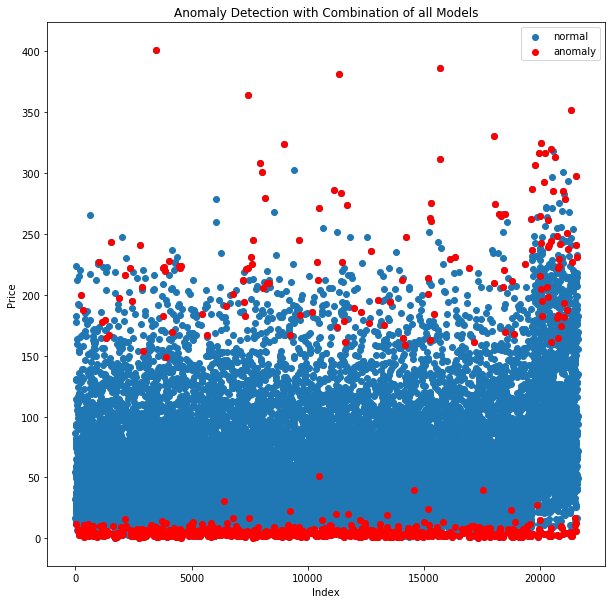

In [38]:
fig, ax = plt.subplots(figsize=[10, 10])

a = df_outliers[['price']]
ax.scatter(df.index, df['price'], label='normal')
ax.scatter(a.index,a['price'], color='red', label='anomaly')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Anomaly Detection with Combination of all Models')
plt.legend()
plt.show()

### Distribution of the anomalies detected by all models

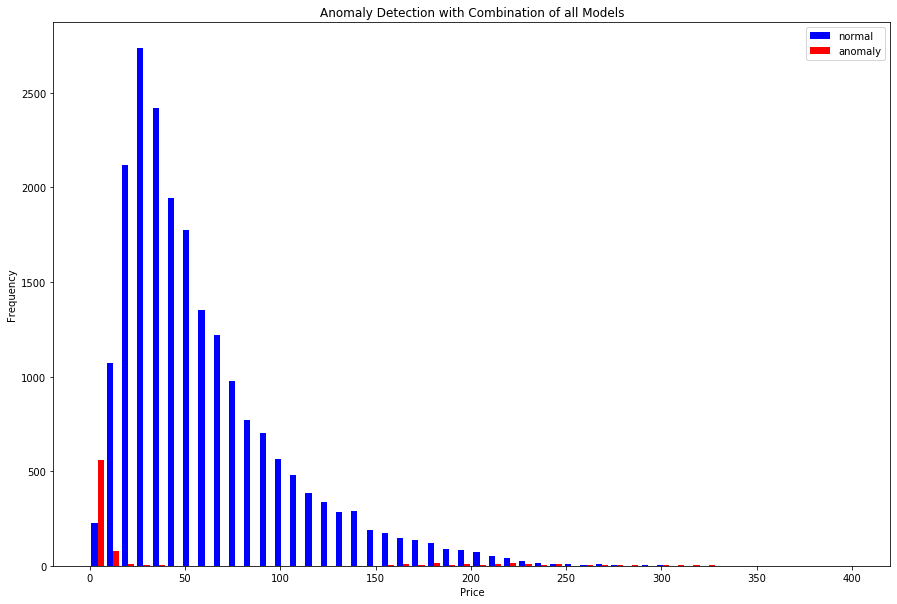

In [39]:
normal = df.loc[df['AnomalyScore'] > -4, 'price']
anomaly = df.loc[df['AnomalyScore'] <= -4, 'price']

fig, axs = plt.subplots(figsize=(15,10))
axs.hist([normal, anomaly], 
         bins=50, 
         stacked=False, 
         color=['blue', 'red'], 
         label=['normal', 'anomaly'])

plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Anomaly Detection with Combination of all Models')
plt.legend()
plt.show()

## Remove the anomalies from the original dataset

In [40]:
df = df[df['AnomalyScore'] > -4]
df = df.drop(columns=['IQR', 
                      'IsolationForest', 
                      'OneClassSVM', 
                      'LocalOutlierFactor', 
                      'RobustCovariance', 
                      'KNN'])
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,AnomalyScore
0,32.489019,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,6830,0
1,54.830819,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,9812,0
2,16.713092,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,10770,0
3,86.781609,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,6960,0
4,52.254098,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,9760,0
6,30.173424,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,8534,0
7,27.095906,3,1.50,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,10771,-1
8,24.810811,3,1.00,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,9250,0
9,38.224852,3,2.50,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,8450,0
10,49.603175,3,2.50,3560,9796,1,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,13356,0


In [41]:
df = df.reset_index()
df = df.drop(columns=['index'])
df.head(10)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft,AnomalyScore
0,32.489019,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,6830,0
1,54.830819,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,9812,0
2,16.713092,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,10770,0
3,86.781609,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,6960,0
4,52.254098,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,9760,0
5,30.173424,3,2.25,1715,6819,2,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,8534,0
6,27.095906,3,1.50,1060,9711,1,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,10771,-1
7,24.810811,3,1.00,1780,7470,1,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,9250,0
8,38.224852,3,2.50,1890,6560,2,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,8450,0
9,49.603175,3,2.50,3560,9796,1,0,0,3,8,1860,1700,1965,0,98007,47.6007,-122.145,13356,0


## Save to file

In [42]:
df.to_csv('kc_house_data.csv')